In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
# pip3 install tensorflow_datasets==4.9.2 dado que 4.9.3 error en windows

c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
datos, metadatos = tfds.load('mnist', as_supervised=True, with_info=True)

In [3]:
metadatos

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='C:\\Users\\Ketbome\\tensorflow_datasets\\mnist\\3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",

In [4]:
datos_entrenamiento, datos_prueba = datos['train'], datos['test']

nombres_clases = metadatos.features['label'].names

In [5]:
# Normalización de los datos
# 0-255 1 byte
# Transformar 0-255 a 0-1 

# Normalizar datos de ent y prueba 
def normalizar(imagenes, etiquetas):
    imagenes = tf.cast(imagenes, tf.float32)
    imagenes /= 255
    return imagenes, etiquetas

datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_prueba = datos_prueba.map(normalizar)

# Agregar en cache
datos_entrenamiento = datos_entrenamiento.cache()
datos_prueba = datos_prueba.cache()

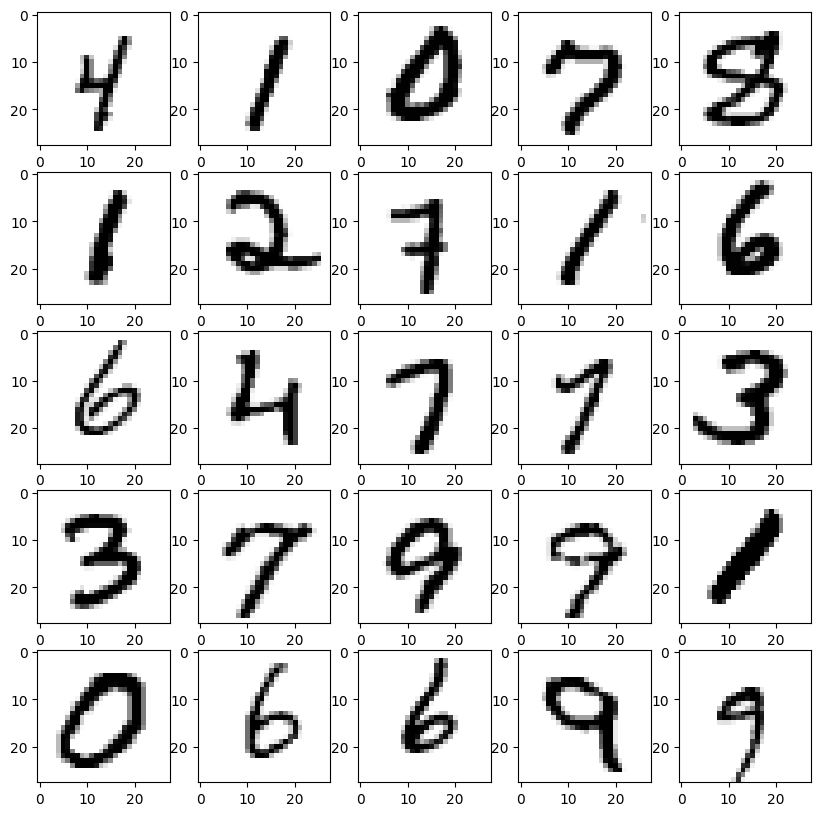

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
    # Graficar
    plt.subplot(5,5, i + 1)
    plt.imshow(imagen, cmap=plt.cm.binary)

plt.show()

In [14]:
modelo = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)), # 28x28 = 784
    # Capa oculta
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    # Capa de salida
    tf.keras.layers.Dense(10, activation=tf.nn.softmax) # 10 clases
])

In [15]:
modelo.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), # permite ajustarse de manera adecuada a la clasificación
    metrics=['accuracy']
)

In [9]:
tamano_lote = 32

datos_entrenamiento = datos_entrenamiento.repeat().shuffle(60000).batch(tamano_lote)
datos_prueba = datos_prueba.batch(tamano_lote)

In [16]:
import math

# Entrenamiento
entrenamiento = modelo.fit(
    datos_entrenamiento, 
    epochs=10, 
    steps_per_epoch=math.ceil(60000/ tamano_lote)
)

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2885 - accuracy: 0.9167
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1348 - accuracy: 0.9592
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1043 - accuracy: 0.9683
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0819 - accuracy: 0.9742
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0670 - accuracy: 0.9788
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0585 - accuracy: 0.9824
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0512 - accuracy: 0.9839
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0445 - accuracy: 0.9857
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0385 - accuracy: 0.9876
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.036

1/1 [==============================] - 0s 121ms/step


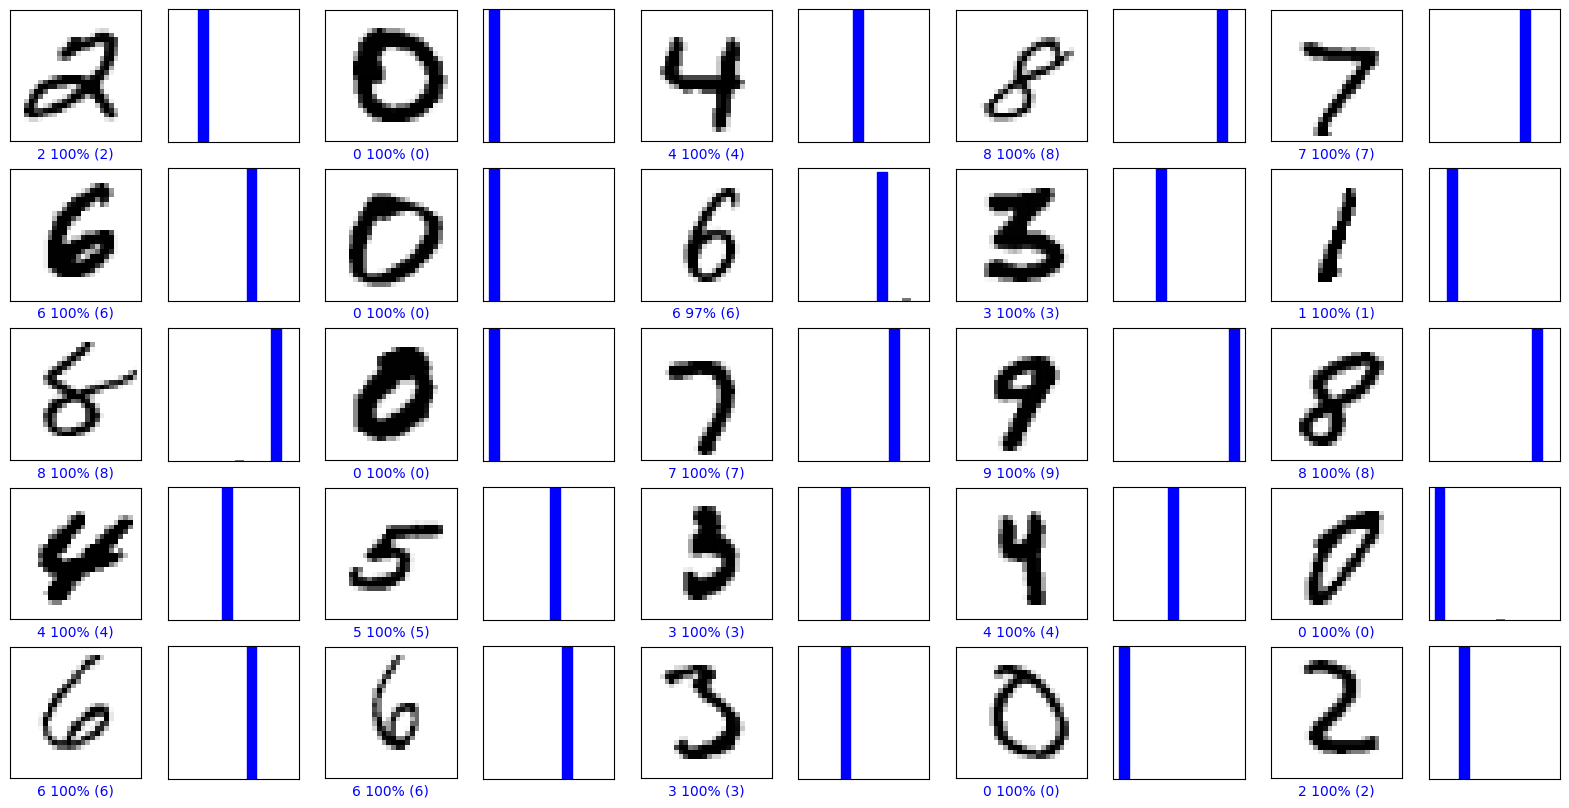

In [17]:
#Pintar una cuadricula con varias predicciones, y marcar si fue correcta (azul) o incorrecta (roja)
import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_prueba.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)
  
def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombres_clases[etiqueta_real]),
                                color=color)
  
def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1]) 
  etiqueta_prediccion = np.argmax(arr_predicciones)
  
  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')
  
filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)